# ClusterShearCatalogs stage functionalities

This notebook aims at presenting the `ClusterShearCatalogs` stage of the TXpipe clusters extension. This stage selects background galaxies for each cluster of a cluster catalog and compute basic shear-related quantities for each of those galaxies (e.g., tangential and cross shear components, weights)

*This notebook was developed by Céline COmbet and Camille Avestruz for the DESC CL_Cosmo_Pipeline team.*
___

In [1]:
import os
from pprint import pprint

import ceci
import h5py

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import yaml
from IPython.display import Image

Make sure to change your path in the next cell that leads to your TXPipe directory. See examples for IN2P3 and NERSC below.

In [2]:
# user specific paths -- IN2P3 example
my_txpipe_dir = "/pbs/home/m/mricci/throng_mricci/desc/TXPipe"
# my_txpipe_dir = "/pbs/throng/lsst/users/ccombet/TXPipe"

# user specific paths -- NERSC example
# my_txpipe_dir = "/pscratch/sd/a/avestruz/TXPipe"

os.chdir(my_txpipe_dir)

import txpipe

# 1 deg$^2$ sample running directly in Jupyter

First we will do some runs on the 1 deg^2 example data set with around 80k galaxies. This is small enough that we can do it all in jupyter.

The data set, which is based on CosmoDC2, contains pre-computed photo-z and and contains a RedMapper cluster catalog for the field.

## This initiates and run the stage

In [3]:
print("Options for this pipeline and their defaults:")
print(txpipe.extensions.CLClusterShearCatalogs.config_options)

Options for this pipeline and their defaults:
{'chunk_rows': 100000, 'max_radius': 10.0, 'delta_z': 0.1, 'redshift_cut_criterion': 'zmode', 'redshift_weight_criterion': 'zmode', 'redshift_cut_criterion_pdf_fraction': 0.9, 'subtract_mean_shear': False, 'coordinate_system': 'celestial', 'use_true_shear': False}


In [4]:
pipe_stage = txpipe.extensions.CLClusterShearCatalogs.make_stage(
    # catalogs
    shear_catalog="data/example/inputs/metadetect_shear_catalog.hdf5",
    cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    source_photoz_pdfs="data/example/inputs/photoz_pdfs.hdf5",
    # Initial sample selection was performed and output in shear_tomography_catalog
    # by previously running the TXSourceSelectorMetadetect stage
    shear_tomography_catalog="data/example/outputs_metadetect/shear_tomography_catalog.hdf5",
    # Fiducial cosmology: it is needed to get physical distances as we are
    # currently selecting sources based on projected distance (in Mpc)
    # from cluster center
    fiducial_cosmology="./data/fiducial_cosmology.yml",
    # This is the output for this stage
    cluster_shear_catalogs="./data/cosmodc2/outputs-1deg2-CL/cluster_shear_catalogs.hdf5",
    # This contains all the options for this stage. Default config options will be updated
    config="./examples/cosmodc2/Cluster_pipelines/config-1deg2-CL.yml",
)

In [5]:
# Check the new config options
pipe_stage.config

StageConfig{chunk_rows:100000,max_radius:5.0,delta_z:0.2,redshift_cut_criterion:ztrue,redshift_weight_criterion:ztrue,redshift_cut_criterion_pdf_fraction:0.9,subtract_mean_shear:False,coordinate_system:celestial,use_true_shear:False,shear_catalog:data/example/inputs/metadetect_shear_catalog.hdf5,cluster_catalog:./data/example/inputs/cluster_catalog.hdf5,source_photoz_pdfs:data/example/inputs/photoz_pdfs.hdf5,shear_tomography_catalog:data/example/outputs_metadetect/shear_tomography_catalog.hdf5,fiducial_cosmology:./data/fiducial_cosmology.yml,cluster_shear_catalogs:./data/cosmodc2/outputs-1deg2-CL/cluster_shear_catalogs.hdf5,config:./examples/cosmodc2/Cluster_pipelines/config-1deg2-CL.yml,}

In [6]:
pipe_stage.run()
pipe_stage.finalize()

Min search angle =  10.055619643143178 arcmin
Mean search angle =  12.982303351021686 arcmin
Max search angle =  22.5465440032851 arcmin
Max theta_max = 0.00655852379671847 radians = 22.5465440032851 arcmin
Using single 2D shear calibration!
Process 0 processing chunk 0 - 82,200
Process 0 done reading
Overall pair count =  62257
Found 914 total galaxies in catalog for cluster 11
Found 768 total galaxies in catalog for cluster 827
Found 729 total galaxies in catalog for cluster 1985
Found 708 total galaxies in catalog for cluster 1632
Found 193 total galaxies in catalog for cluster 2453
Found 869 total galaxies in catalog for cluster 2678
Found 374 total galaxies in catalog for cluster 4643
Found 110 total galaxies in catalog for cluster 5084
Found 685 total galaxies in catalog for cluster 4434
Found 537 total galaxies in catalog for cluster 3939
Found 1459 total galaxies in catalog for cluster 6139
Found 450 total galaxies in catalog for cluster 4709
Found 1326 total galaxies in catalo

## Checking out the output

To avoid making lots and lots of copies of the data, this stage has not made a catalog, but instead made an index into the other catalogs, and stored only the new derived quantities.

We have a helper class which is designed to match up all the different catalogs that go into this and collect the results for each cluster.

In [7]:
ccc = txpipe.extensions.CombinedClusterCatalog(
    shear_catalog="./data/example/inputs/metadetect_shear_catalog.hdf5",
    shear_tomography_catalog="./data/example/outputs_metadetect/shear_tomography_catalog.hdf5",
    cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    cluster_shear_catalogs="./data/cosmodc2/outputs-1deg2-CL/cluster_shear_catalogs.hdf5",
    source_photoz_pdfs="./data/example/inputs/photoz_pdfs.hdf5",
)

In [8]:
print(f"We have {ccc.ncluster} clusters")

We have 75 clusters


We can extract the cluster catalog info by index (0 -- 74):

In [9]:
ind = 0
cluster_info = ccc.get_cluster_info(ind)
cluster_info

{'cluster_id': 11,
 'dec': -30.89586711375849,
 'ra': 60.69667268260482,
 'redshift': 0.49929956,
 'redshift_err': 0.0029379127,
 'richness': 167.65639,
 'richness_err': 2.9917574,
 'scaleval': 0.99996734}

And also the shear catalog associated with that cluster, again by index, in the CLMM data format

In [10]:
bg_cat = ccc.get_background_shear_catalog(ind)
bg_cat[0:3]

cluster_id,cluster_index,cross_comp,distance_arcmin,g1,g2,source_index,tangential_comp,weight,true_g1,true_g2
int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64
11,0,-1377465714314899.5,11.338039423112267,-0.15311780914373768,0.2664932287791221,17162,-649679259437375.2,4.07259800687573e-32,-0.007003703080271095,-0.0007417583253108676
11,0,220677786627996.94,9.459996655159163,0.1853480428132408,-0.05232620202325153,17171,923831976254965.6,4.111438710586925e-32,0.016970898542173596,0.0006234910020593214
11,0,-481132076599606.06,8.894840509992234,-0.10459936161236871,0.01160827358665681,17182,216719662217806.78,3.9775759421152165e-32,-0.004409851063769843,0.0017223855979893957


In [32]:
bg_cat = ccc.get_background_shear_catalog(ind)
bg_cat[0:3]

cluster_id,cluster_index,cross_comp,distance_arcmin,g1,g2,source_index,tangential_comp,weight,true_g1,true_g2
int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64
11,0,-26372768703921.79,11.338039423112267,-0.007003703080271095,-0.0007417583253108676,17162,22856585620169.875,4.07259800687573e-32,-0.007003703080271095,-0.0007417583253108676
11,0,43515985004265.56,9.459996655159163,0.016970898542173596,0.0006234910020593214,17171,71560733530445.03,4.111438710586925e-32,0.016970898542173596,0.0006234910020593214
11,0,-23429560685094.137,8.894840509992234,-0.004409851063769843,0.0017223855979893957,17182,3814394445651.339,3.9775759421152165e-32,-0.004409851063769843,0.0017223855979893957


In [11]:
len(bg_cat["source_index"])

914

In [12]:
bg_cat.meta

GCMetaData([('coordinate_system', 'celestial'), ('cosmo', None)])

In [13]:
import clmm
clmm_cosmo = clmm.cosmology.ccl.CCLCosmology()
clmm_cosmo.set_be_cosmo()

In [14]:
prof_Mpc = clmm.make_radial_profile( [bg_cat["tangential_comp"], bg_cat["cross_comp"]], bg_cat["distance_arcmin"],
                     "arcmin", "Mpc", bins=6, cosmo=clmm_cosmo , z_lens=cluster_info['redshift'], weights= bg_cat["weight"])

/pbs/throng/lsst/users/mricci/desc/TXPipe/conda/lib/python3.10/site-packages/clmm/dataops/__init__.py:567: UserWarning: coordinate_system not set, defaulting to 'euclidean'.
  warnings.warn("coordinate_system not set, defaulting to 'euclidean'.")


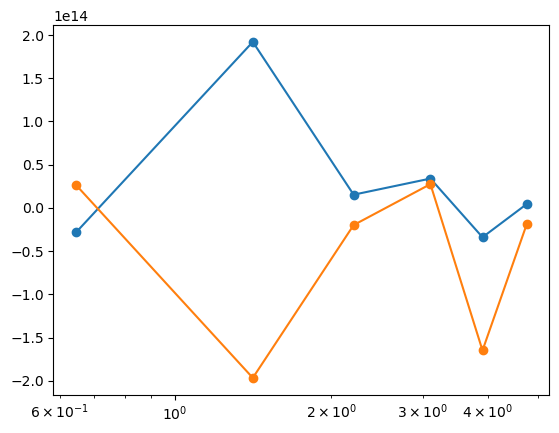

In [15]:
plt.semilogx(prof_Mpc["radius"], prof_Mpc["p_0"], "o-")
plt.semilogx(prof_Mpc["radius"], prof_Mpc["p_1"], "o-")

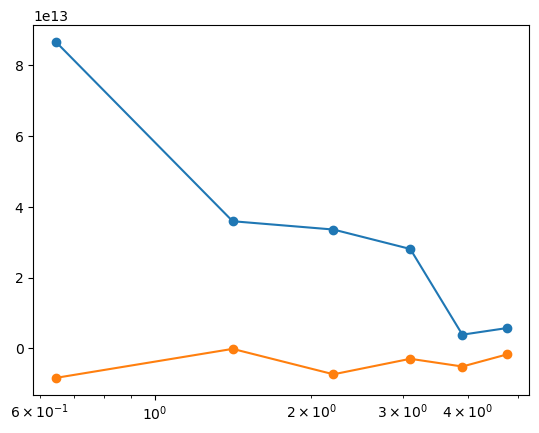

In [38]:
plt.semilogx(prof_Mpc["radius"], prof_Mpc["p_0"], "o-")
plt.semilogx(prof_Mpc["radius"], prof_Mpc["p_1"], "o-")

# 20 deg$^2$ example using the pipeline approach

In [5]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/Cluster_pipelines/CLClusterShearCat-20deg2-CL.yml"
flowchart_file = "CLClusterShearCat.png"

pipeline_config = ceci.Pipeline.build_config(
    pipeline_file, flow_chart=flowchart_file, dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config);

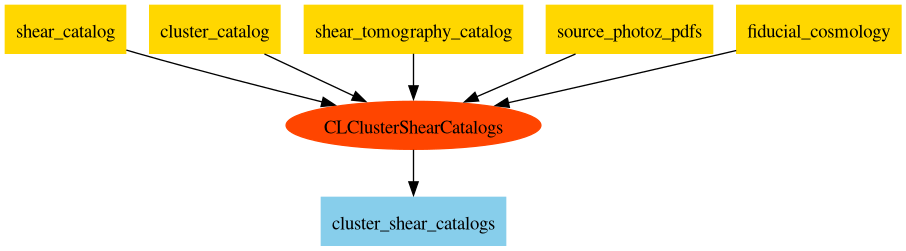

In [6]:
Image(flowchart_file)

In [7]:
ccc = txpipe.extensions.CombinedClusterCatalog(
    shear_catalog="./data/cosmodc2/20deg2/shear_catalog.hdf5",
    shear_tomography_catalog="./data/cosmodc2/outputs-20deg2-CL/shear_tomography_catalog.hdf5",
    cluster_catalog="./data/cosmodc2/20deg2/cluster_catalog.hdf5",
    cluster_shear_catalogs="./data/cosmodc2/outputs-20deg2-CL/cluster_shear_catalogs.hdf5",
    source_photoz_pdfs="./data/cosmodc2/outputs-20deg2-CL/source_photoz_pdfs.hdf5",
)

In [8]:
# Get the path to the data files
data_dir = "data/cosmodc2/20deg2"

# open the cluster and shear catalogs
clusters = h5py.File(os.path.join(data_dir, "cluster_catalog.hdf5"), "r")
shear = h5py.File(os.path.join(data_dir, "shear_catalog.hdf5"), "r")

In [9]:
ccc = txpipe.extensions.CombinedClusterCatalog.from_pipeline_file(pipeline_file)

In [10]:
array([4345., 4252., 4136., 6091., 7122.])

NameError: name 'array' is not defined

In [11]:
print(f"We have {ccc.ncluster} clusters")

We have 1942 clusters


In [12]:
cluster_z = clusters['clusters/redshift'][:]
cluster_richness = clusters['clusters/richness'][:]
cluster_id = clusters['clusters/cluster_id'][:]

In [13]:
ind = np.where(cluster_id==4252)[0][0]
ind

1045

In [14]:
cluster_info = ccc.get_cluster_info(ind)
cluster_info

{'cluster_id': 4252,
 'dec': -27.155095573328158,
 'ra': 52.03598123956394,
 'redshift': 0.24286394,
 'redshift_err': 0.0049778083,
 'richness': 22.398516,
 'richness_err': 1.9628164,
 'scaleval': 1.0001469}

In [15]:
bg_cat = ccc.get_background_shear_catalog(ind)
bg_cat[0:3]

source_index,weight,tangential_comp,cross_comp,g1,g2,distance_arcmin,true_g1,true_g2
int64,float64,float64,float64,float64,float64,float64,float64,float64
4308695,1.5562486774762743e-31,-1485828543.2069857,-68477700668.301796,-2.6601331744369183e-05,4.740057819199361e-06,18.741731287886402,-2.6601331744369183e-05,4.740057819199361e-06
4309002,1.5644519690320322e-31,-27670033803.357002,-58617526802.14963,-1.3740180219601328e-05,2.164566148560017e-05,17.36985489058113,-1.3740180219601328e-05,2.164566148560017e-05
4309192,1.5525980773867177e-31,-13754437331.028744,23346938530.752056,7.52293108152724e-06,-7.576754491018102e-06,15.498376506080431,7.52293108152724e-06,-7.576754491018102e-06


In [16]:
cl_ind = (4252)
cl_ind

AttributeError: 'CombinedClusterCatalog' object has no attribute 'get_cluster_indice'

In [17]:
txpipe.extensions.cluster_counts.get_cluster_shear_catalogs_index_from_cluster_id(4252)

NameError: name 'self' is not defined

In [28]:
ccc.cluster_shear_catalogs['catalog/cluster_id'][200000]

IndexError: Index (200000) out of range for (0-1941)

In [27]:
ccc.cluster_shear_catalogs['index/cluster_index'][200000]

12

In [47]:
n

SyntaxError: invalid syntax (2576814326.py, line 1)

In [13]:
np.max(bg_cat["distance_arcmin"])

21.946063927199358

In [14]:
len(bg_cat)

31474

In [15]:
gal_ra = shear["shear/00/ra"][bg_cat["source_index"]]
gal_dec = shear["shear/00/dec"][bg_cat["source_index"]]

In [16]:
gal_ra.size

31474

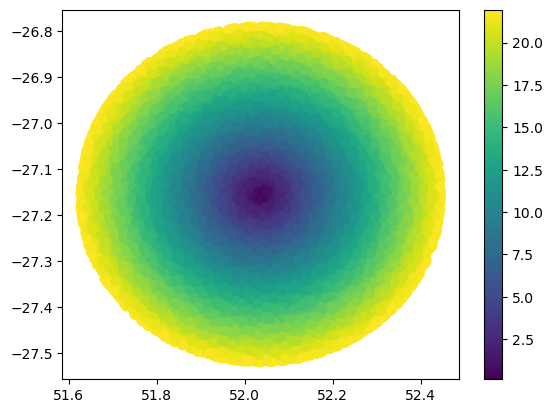

In [17]:
plt.scatter(gal_ra, gal_dec, c = bg_cat["distance_arcmin"])
plt.colorbar()

In [18]:
import clmm

In [19]:
clmm_cosmo = clmm.cosmology.ccl.CCLCosmology()
clmm_cosmo.set_be_cosmo()

In [20]:
dist_Mpc = clmm.utils.convert_units(bg_cat["distance_arcmin"],'arcmin', 'Mpc', 
                         cluster_info['redshift'], clmm_cosmo)

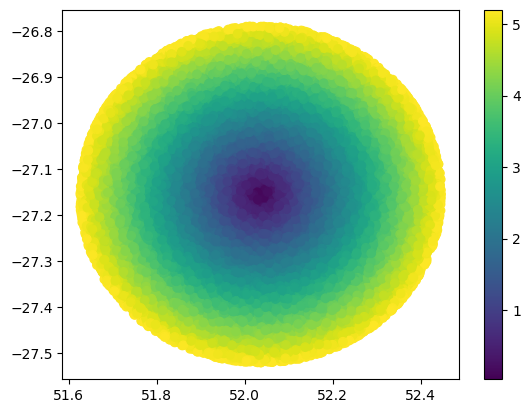

In [21]:
plt.scatter(gal_ra, gal_dec, c = dist_Mpc)
plt.colorbar()

In [22]:
bg_cat

source_index,weight,tangential_comp,cross_comp,g1,g2,distance_arcmin,true_g1,true_g2
int64,float64,float64,float64,float64,float64,float64,float64,float64
4308695,1.5562486774762743e-31,-1485828543.2069857,-68477700668.301796,-2.6601331744369183e-05,4.740057819199361e-06,18.741731287886402,-2.6601331744369183e-05,4.740057819199361e-06
4309002,1.5644519690320322e-31,-27670033803.357002,-58617526802.14963,-1.3740180219601328e-05,2.164566148560017e-05,17.36985489058113,-1.3740180219601328e-05,2.164566148560017e-05
4309192,1.5525980773867177e-31,-13754437331.028744,23346938530.752056,7.52293108152724e-06,-7.576754491018102e-06,15.498376506080431,7.52293108152724e-06,-7.576754491018102e-06
4309197,4.992542787010545e-32,27675217896.16829,50362776886.69647,2.1245308507999994e-06,1.266319296916739e-05,15.743299505768148,2.1245308507999994e-06,1.266319296916739e-05
4309241,1.5998426606346333e-31,-3031658916.331304,-3747824713.9287643,1.6050392516175904e-06,-1.0683757430779791e-06,14.175610704321471,1.6050392516175904e-06,-1.0683757430779791e-06
4309276,4.992542787010545e-32,-52536529678.248436,-87859575956.02483,-8.042522829820875e-06,2.141275222473397e-05,2.380391053177298,-8.042522829820875e-06,2.141275222473397e-05
4309403,1.5488623354700628e-31,337402811282.5325,-135689414653.49994,0.00014239056325043853,1.4456283864842373e-05,8.191801407988025,0.00014239056325043853,1.4456283864842373e-05
4309430,4.7917242486501057e-32,-1196234720769.6672,-767614832728.971,0.00029753502325102765,9.097144734635101e-05,14.103482355251533,0.00029753502325102765,9.097144734635101e-05
4309486,1.546323130224833e-31,-731252150782.7134,80858088364.53186,0.00028599088665215433,4.3665720161980176e-05,19.07170373813495,0.00028599088665215433,4.3665720161980176e-05


In [23]:
prof_Mpc = clmm.make_radial_profile( [bg_cat["tangential_comp"], bg_cat["cross_comp"]], bg_cat["distance_arcmin"],
                     "arcmin", "Mpc", cosmo=clmm_cosmo , z_lens=cluster_info['redshift'], weights= bg_cat["weight"])

In [24]:
prof

NameError: name 'prof' is not defined

In [ ]:
prof_Mpc

In [25]:
plt.semilogx(prof["radius"], prof["p_0"], "o-")
plt.semilogx(prof["radius"], prof["p_1"], "o-")

NameError: name 'prof' is not defined

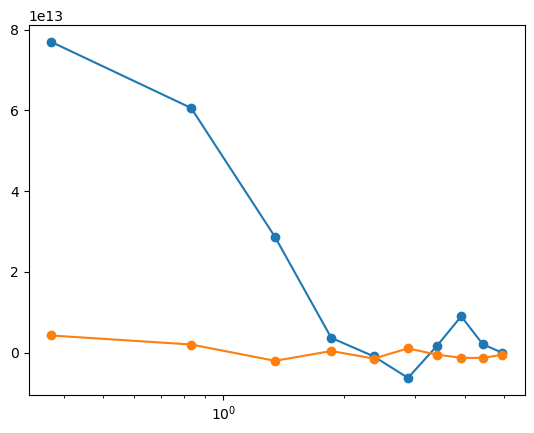

In [26]:
plt.semilogx(prof_Mpc["radius"], prof_Mpc["p_0"], "o-")
plt.semilogx(prof_Mpc["radius"], prof_Mpc["p_1"], "o-")

In [27]:
radial_bins = clmm.dataops.make_bins(0.2, 5., nbins=10, method="evenlog10width")
radial_bins

array([0.2       , 0.27594593, 0.38073079, 0.52530556, 0.72477966,
       1.        , 1.37972966, 1.90365394, 2.6265278 , 3.62389832,
       5.        ])

In [28]:
prof_rad = clmm.make_radial_profile( [bg_cat["tangential_comp"], bg_cat["cross_comp"]], bg_cat["distance_arcmin"],
                     "arcmin", "Mpc", bins=radial_bins, cosmo=clmm_cosmo , z_lens=cluster_info['redshift'], weights= bg_cat["weight"])

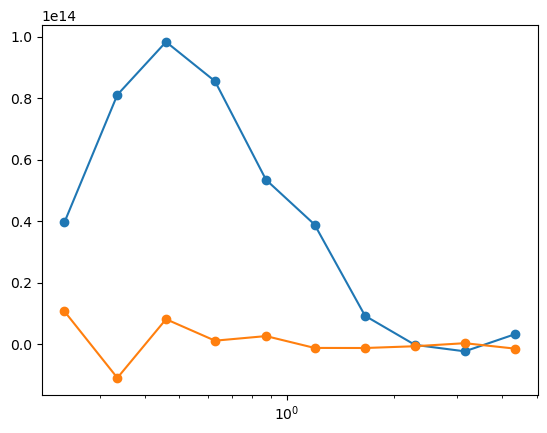

In [29]:
plt.semilogx(prof_rad["radius"], prof_rad["p_0"], "o-")
plt.semilogx(prof_rad["radius"], prof_rad["p_1"], "o-")

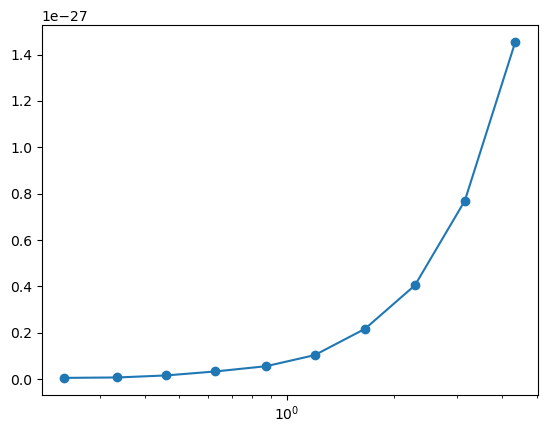

In [30]:
plt.semilogx(prof_rad["radius"], prof_rad["weights_sum"], "o-")

(0.0, 1000.0)

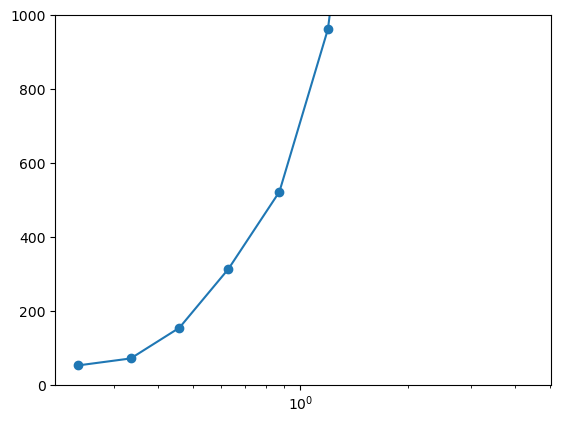

In [31]:
plt.semilogx(prof_rad["radius"], prof_rad["n_src"], "o-")
plt.ylim(0,1000)

Text(0, 0.5, 'g1')

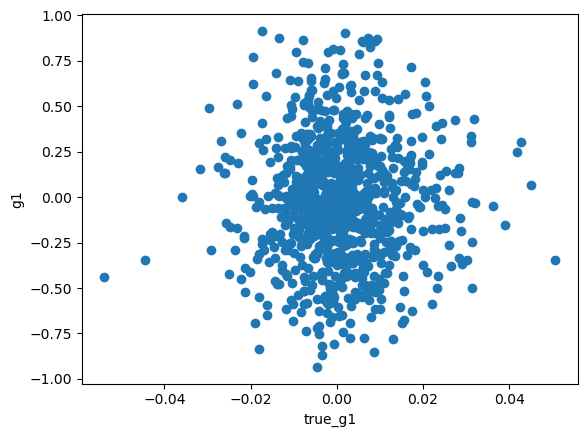

In [42]:
plt.scatter(bg_cat['true_g1'], bg_cat['g1'])
plt.xlabel('true_g1')
plt.ylabel('g1')

Text(0, 0.5, 'g2')

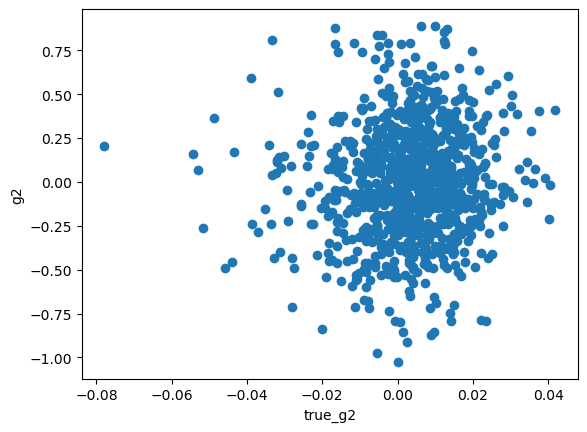

In [46]:
plt.scatter(bg_cat['true_g2'], bg_cat['g2'])
plt.xlabel('true_g2')
plt.ylabel('g2')

In [25]:
radial_bins = clmm.dataops.make_bins(0.2, 5., nbins=10, method="evenlog10width")
radial_bins

array([0.2       , 0.27594593, 0.38073079, 0.52530556, 0.72477966,
       1.        , 1.37972966, 1.90365394, 2.6265278 , 3.62389832,
       5.        ])

In [37]:

galcat = clmm.GCData(bg_cat, meta=bg_cat.meta)
galcat['theta'] = galcat['distance_arcmin']*np.pi/(60*180) # CLMM galcat requires a column called "theta" in radians
galcat['z'] = np.zeros(len(galcat)) # clmm needs a column named 'z' but all computation have been done                    
                
gc_object = clmm.GalaxyCluster(np.int(cluster_info['cluster_id']), cluster_info['ra'], cluster_info['dec'],
                               cluster_info['redshift'], galcat )

In [40]:
plt.plot(

cluster_id,cluster_index,cross_comp,distance_arcmin,g1,g2,source_index,tangential_comp,weight,true_g1,true_g2,theta,z
int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
11,0,-132440606665876.02,11.338039423112267,-0.15311780914373768,0.2664932287791221,17162,1517219305163933.0,4.07259800687573e-32,-0.007003703080271095,-0.0007417583253108676,0.0032981019775704585,0.0
11,0,-671213345143671.9,9.459996655159163,0.1853480428132408,-0.05232620202325153,17171,672039322631666.4,4.111438710586925e-32,0.016970898542173596,0.0006234910020593214,0.002751801481002967,0.0
11,0,421907628513522.0,8.894840509992234,-0.10459936161236871,0.01160827358665681,17182,316937596581638.5,3.9775759421152165e-32,-0.004409851063769843,0.0017223855979893957,0.0025874042223189343,0.0
11,0,-1134539397344154.2,8.890878391232574,-0.2568493130141301,0.2201046796189252,17210,1223907424639550.2,4.108162976541095e-32,-0.0034421241019633175,0.007162188203701769,0.0025862516886904162,0.0
11,0,2283187612414443.5,8.8299591026998,0.2718272714538585,-0.4406099044566496,17211,-1145125481941202.0,4.108162976541095e-32,-0.003098886300219039,0.007199926836771924,0.002568530985975927,0.0
11,0,-1796001315549834.0,9.605506667847397,0.3385905434163665,-0.3369438423961739,17214,1527609146301530.0,4.104444541552719e-32,-0.009520373082449574,-0.008351261459661675,0.0027941286279367736,0.0
11,0,-70096118840582.02,7.458816181440183,-0.16216395010389717,-0.14399846184774626,17227,1140909314384947.2,3.599659622103396e-32,-0.0034966405317268245,0.009922972410272405,0.0021696816777860327,0.0
11,0,-122606125715295.48,9.551568281025906,-0.03721687535676625,-0.14813305667227963,17228,-797431609664441.8,3.5838751585538416e-32,0.003443697521779532,0.0005379004706157356,0.0027784385872159515,0.0
11,0,1968965318275440.2,9.323021124212982,-0.36139376235575577,0.10685474051791055,17229,-293291194514254.5,3.5838751585538416e-32,0.0037164293772732893,0.0004387279417470925,0.0027119569141749963,0.0


In [38]:
gc_object.make_radial_profile(
                    "Mpc", 
                    bins=radial_bins,
                    cosmo=clmm_cosmo, 
                    tan_component_in = "tangential_comp", # name given in the CLClusterShearCatalogs stage
                    cross_component_in = "cross_comp", # name given in the CLClusterShearCatalogs stage
                    tan_component_out = "tangential_comp2",
                    cross_component_out = "cross_comp2",
                    use_weights=True,
                    weights_in = "weight", # name given in the CLClusterShearCatalogs stage
                    weights_out = "W_l",
                    include_empty_bins = True, 
                       )


radius_min,radius,radius_max,tangential_comp2,tangential_comp2_err,cross_comp2,cross_comp2_err,z,z_err,n_src,W_l
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0.20000000000000004,0.21267279206965364,0.27594593229224296,-1579269224431349.5,0.0,-905900117577643.1,0.0,0.0,0.0,1,9.235987691997374e-32
0.27594593229224296,0.340765302833972,0.38073078774317576,87291689679734.48,532855489766966.56,199191317415320.44,601543571774483.4,0.0,0.0,3,3.615317967850574e-31
0.38073078774317576,0.4395819992857978,0.5253055608807535,39488423818618.266,400167279705294.5,-272920401237184.12,331730476708011.25,0.0,0.0,6,6.812962583764337e-31
0.5253055608807535,0.6365459405499849,0.7247796636776956,-75934444913419.22,202938064231487.53,331668776847559.8,232564036669791.3,0.0,0.0,11,1.4738607836529992e-30
0.7247796636776956,0.8584818297330159,1.0,-104793511413367.08,183220056761365.53,26234178941806.242,210673034407541.1,0.0,0.0,22,2.620633156615008e-30
1.0,1.2193154625565261,1.3797296614612151,285897148127753.94,211272911425623.5,-100406570307016.47,227807543212344.34,0.0,0.0,30,3.628110249651055e-30
1.3797296614612151,1.6383679851496367,1.9036539387158786,337031939297604.25,144995400120679.28,-13977250464070.55,140839601107415.94,0.0,0.0,53,7.195032791291217e-30
1.9036539387158786,2.2387749996127804,2.6265278044037674,-41896065449253.4,100637530853296.94,-134235498262041.39,107617847179893.61,0.0,0.0,107,1.4472909975004612e-29
2.6265278044037674,3.1704982816942304,3.6238983183884783,-32381252725849.418,68378635966603.09,106219607376808.8,64132792276701.9,0.0,0.0,237,2.896118248462581e-29


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Radius [Mpc]', ylabel='tangential_comp2 | cross_comp2'>)

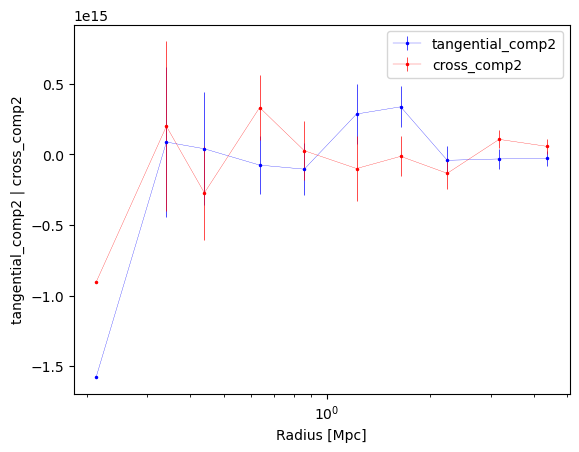

In [39]:
gc_object.plot_profiles('tangential_comp2', 'tangential_comp2_err', 'cross_comp2', 'cross_comp2_err', xscale='log')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Radius [Mpc]', ylabel='tangential_comp2 | cross_comp2'>)

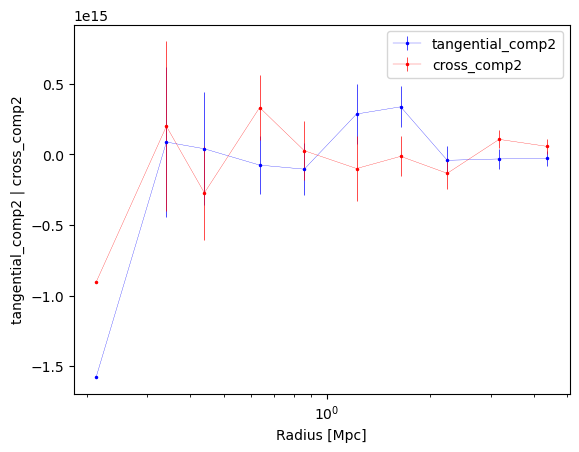

In [31]:
gc_object.plot_profiles('tangential_comp2', 'tangential_comp2_err', 'cross_comp2', 'cross_comp2_err', xscale='log')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Radius [Mpc]', ylabel='tangential_comp2 | cross_comp2'>)

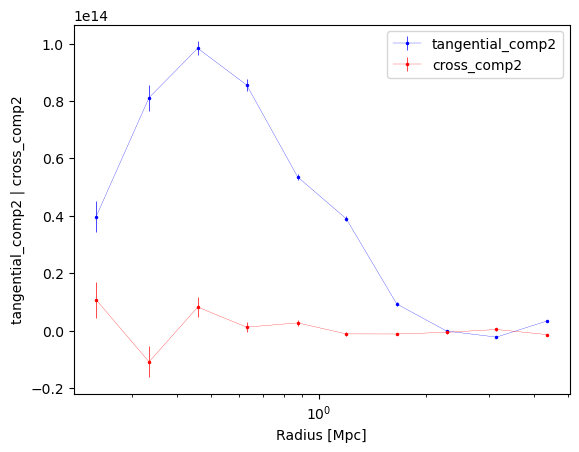

In [34]:
gc_object.plot_profiles('tangential_comp2', 'tangential_comp2_err', 'cross_comp2', 'cross_comp2_err', xscale='log')

In [40]:
txpipe.extensions.CombinedClusterCatalog.get_cluster_indice(self, cluster_id = cluster_info['cluster_id'])

NameError: name 'self' is not defined

In [37]:
cluster_ensemble = clmm.ClusterEnsemble(0)

In [54]:
cluster_ensemble.add_individual_radial_profile(
                    galaxycluster=gc_object,
                    profile_table=gc_object.profile, 
                    tan_component="tangential_comp2",
                    cross_component="cross_comp2",
                    weights="W_l")

In [84]:
gc_object.make_radial_profile(
                    "Mpc", 
                    bins=radial_bins,
                    cosmo=clmm_cosmo, 
                    tan_component_in = "tangential_comp", # name given in the CLClusterShearCatalogs stage
                    cross_component_in = "cross_comp", # name given in the CLClusterShearCatalogs stage
                    tan_component_out = "tangential_comp",
                    cross_component_out = "cross_comp",
                    use_weights=True,
                    weights_in = "weight", # name given in the CLClusterShearCatalogs stage
                    weights_out = "W_l",
                    include_empty_bins = True 
                    )


TypeError: Shear or ellipticity information is missing. Galaxy catalog must have tangentialand cross shears (gt, gx) or ellipticities (et, ex). Run compute_tangential_and_cross_components first.

In [74]:
txpipe.extensions.CLClusterEnsembleProfiles.create_cluster_ensemble(radial_bins,clmm_cosmo,cluster_info,bg_cat)

TypeError: CLClusterEnsembleProfiles.create_cluster_ensemble() missing 1 required positional argument: 'cluster_shears_cat'

In [ ]:
txpipe.extensions.CLClusterEnsembleProfiles.create_cluster_ensemble

In [81]:
comp = clmm.dataops.compute_tangential_and_cross_components(
    cluster_info["ra"],
    cluster_info["dec"],
    bg_cat["ra"],
    bg_cat["dec"],
    bg_cat["e1"],
    bg_cat["e2"],
    coordinate_system="euclidean",
)

In [89]:
comp = clmm.dataops.compute_tangential_and_cross_components(
    cluster_info["ra"],
    cluster_info["dec"],
    bg_cat["ra"],
    bg_cat["dec"],
    bg_cat["e1"],
    bg_cat["e2"],
    coordinate_system="celestial",
)

In [90]:
prof = clmm.make_radial_profile(comp, bg_cat["distance_arcmin"], "arcmin", "arcmin")

In [91]:
prof

radius_min,radius,radius_max,p_0,p_0_err,p_1,p_1_err,p_2,p_2_err,n_src,weights_sum
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
0.0,0.9048984443009546,1.403914490774992,0.00026322428748710243,9.470525567952654e-06,0.0003111165704694687,0.030958184423076705,0.020082687923298616,0.02807775198094879,108,108.0
1.403914490774992,2.1694939450900184,2.807828981549984,0.0006310802073983593,6.277885485753274e-06,0.009349573001234648,0.01585165143285946,0.0011274136606933877,0.015105884977522625,325,325.0
2.807828981549984,3.5390982252592638,4.211743472324976,0.0010294819430376988,4.933882499824821e-06,0.000507977260410371,0.011900839718353127,0.0016399769809633488,0.01225547581762401,541,541.0
4.211743472324976,4.942056256811476,5.615657963099968,0.0014375858916691113,4.4093735022952785e-06,0.014349371143845222,0.010405262443768265,-0.0035641601733755737,0.010509277627826458,736,736.0
5.615657963099968,6.368595638045602,7.019572453874961,0.001852549376867416,3.885730841798387e-06,0.030798193887840046,0.009625939315370226,0.011592157609121422,0.009634986443024827,924,924.0
7.019572453874961,7.730792417458225,8.423486944649952,0.002248796357880964,3.5368723882833518e-06,-0.007073372372699829,0.008562364797977319,-0.004905921020001593,0.008931842999822878,1139,1139.0
8.423486944649952,9.160487356447742,9.827401435424944,0.0026646777576220713,3.28481383160835e-06,0.0015192350354001681,0.008551172581146885,-0.006475853414613587,0.008638919936091827,1293,1293.0
9.827401435424944,10.551910147251412,11.231315926199937,0.0030694262407356234,2.989543601633086e-06,0.0008307359317732815,0.007813250268334642,-0.00035271893764944856,0.0077259174327367515,1570,1570.0
11.231315926199937,11.941349983859444,12.63523041697493,0.003473597905855309,2.7813291491757175e-06,0.017683034134118928,0.007025327240142672,0.0005131708418419774,0.007131502236586348,1757,1757.0


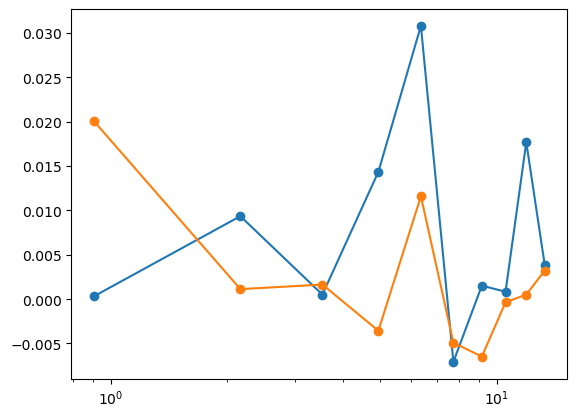

In [92]:
plt.semilogx(prof["radius"], prof["p_1"], "o-")
plt.semilogx(prof["radius"], prof["p_2"], "o-")

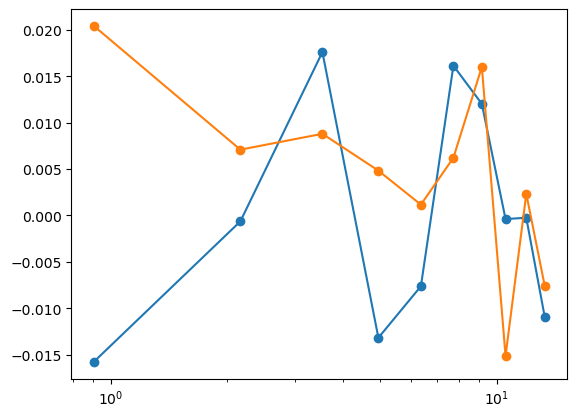

In [84]:
plt.semilogx(prof["radius"], prof["p_1"], "o-")
plt.semilogx(prof["radius"], prof["p_2"], "o-")

In [85]:
clmm.dataops.compute_tangential_and_cross_components(
    cluster_info["ra"],
    cluster_info["dec"],
    bg_cat["ra"],
    bg_cat["dec"],
    bg_cat["e1"],
    bg_cat["e2"],
    coordinate_system="celestial",
)

(array([0.0033342 , 0.00353476, 0.00012282, ..., 0.0023312 , 0.00338886,
        0.001035  ]),
 array([-0.4730875 ,  0.65235143, -0.47529549, ...,  0.00509239,
         0.00587522, -0.07689193]),
 array([-1.10784107,  0.0594187 ,  0.53015064, ...,  0.0030576 ,
         0.60804175, -0.2658378 ]))

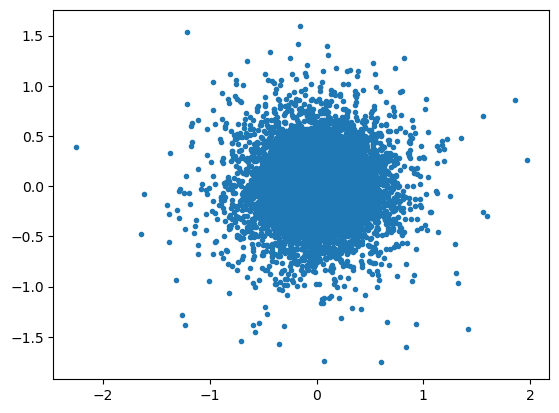

In [86]:
plt.scatter(bg_cat["e1"], bg_cat["e2"], marker=".")

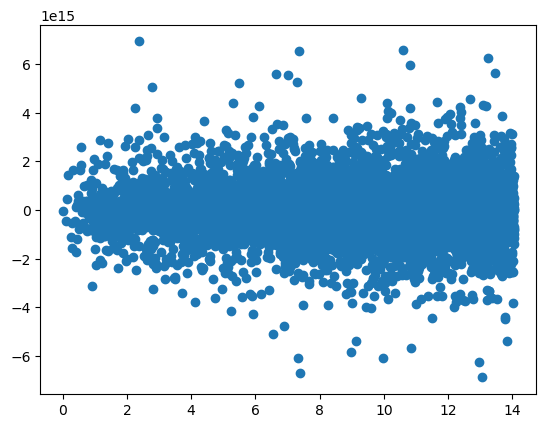

In [87]:
plt.scatter(bg_cat["distance_arcmin"], bg_cat["tangential_comp_clmm"])

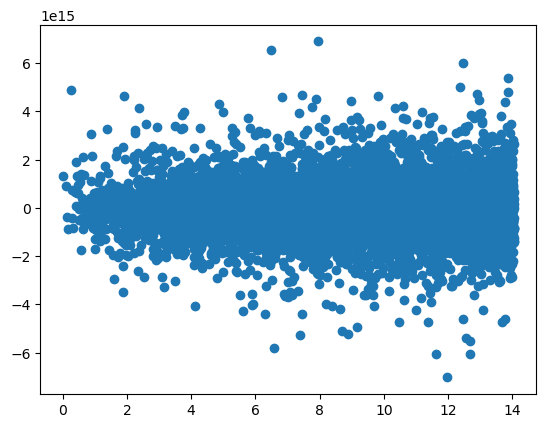

In [88]:
plt.scatter(bg_cat["distance_arcmin"], bg_cat["cross_comp_clmm"])